
#Lab.7: Word Sequences

Authors:<br>
* Ramón Mateo Navarro
* Benet Manzanares Salor

##Installation ans imports

In [1]:
import os
import pandas as pd

import nltk
from nltk.metrics import jaccard_distance
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('maxent_ne_chunker')
nltk.download('conll2000')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

import spacy
nlp = spacy.load("en_core_web_sm")

!pip install svgling
import svgling

from argparse import Namespace
from google.colab import drive
from scipy.stats import pearsonr

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
     |████████████████████████████████| 66 kB 3.9 MB/s 


## Settings


In [2]:
settings = Namespace()

settings.mount_path = "/content/drive/"
drive.mount(settings.mount_path, force_remount=True)

settings.project_folder = "/content/drive/MyDrive/Benet_MAI/S1/IHLT/IHLT_Labs/Lab7" #@param ["/content/drive/MyDrive/MAI/IHLT/IHTL_Labs/Lab7", "/content/drive/MyDrive/Benet_MAI/S1/IHLT/IHLT_Labs/Lab7"]
settings.project_path = os.path.join(os.path.join(settings.mount_path, "MyDrive"), settings.project_folder)
settings.input_filename = "STS.input.SMTeuroparl.txt" #@param {type:"string"}
settings.input_filepath = os.path.join(settings.project_path, settings.input_filename)
settings.gs_filename = "STS.gs.SMTeuroparl.txt" #@param {type:"string"}
settings.gs_filepath = os.path.join(settings.project_path, settings.gs_filename)

Mounted at /content/drive/


## Data

In [3]:
dt = pd.read_csv(settings.input_filepath,sep='\t', header=None)
dt['gs'] = pd.read_csv(settings.gs_filepath, sep='\t', header=None)
dt.head()

,0,1,gs
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,4.50
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,5.00
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,4.25
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,4.50
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...",5.00


## Experiment

In [4]:
wnl = WordNetLemmatizer() # Create lemmatizer

In [5]:
# Functions
def nltk_lemmas_jaccard(sentences):
  sent1, sent2 = sentences
  tags1 = nltk.pos_tag(nltk.word_tokenize(sent1))
  tags2 = nltk.pos_tag(nltk.word_tokenize(sent2))
  lemmas1 = [lemmatize(pair) for pair in tags1]
  lemmas2 = [lemmatize(pair) for pair in tags2]
  return 1 - jaccard_distance(set(lemmas1), set(lemmas2))


def lemmatize(p):
    if p[1][0] in ["NN", "NNS", "NNP", "NNPS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ", "RB", "RBR", "RBS", "JJ", "JJR", "JJS"]:
        return wnl.lemmatize(p[0].lower(), pos=p[1][0].lower())
    return p[0]


def nltk_chunks_jaccard(sentences):  
  sent1, sent2 = sentences
  tags1 = nltk.pos_tag(nltk.word_tokenize(sent1))
  tags2 = nltk.pos_tag(nltk.word_tokenize(sent2))
  words1_tree = nltk.ne_chunk(tags1, binary=True)
  words2_tree = nltk.ne_chunk(tags2, binary=True)
  words1_chunk = nltk.tree2conllstr(words1_tree)
  words2_chunk = nltk.tree2conllstr(words2_tree)
  return 1 - jaccard_distance(set(words1_chunk), set(words2_chunk))


def spacy_words_jaccard(sentences):
  sent1, sent2 = sentences
  doc1 = nlp(sent1)
  doc2 = nlp(sent2)
  list_doc1 = [token.text for token in doc1]
  list_doc2 = [token.text for token in doc2]
  return 1 - jaccard_distance(set(list_doc1), set(list_doc2))


def spacy_chunks_jaccard(sentences):
  sent1, sent2 = sentences
  doc1 = nlp(sent1)
  doc2 = nlp(sent2)
  list_doc1 = get_spacy_chunks(doc1)
  list_doc2 = get_spacy_chunks(doc2)
  return 1 - jaccard_distance(set(list_doc1), set(list_doc2))


def get_spacy_chunks(doc):
  chunks = []
  current_chunk = ""
  last_was_in_chunk = False
  for token in doc:
    if token.ent_iob_ == "B":
      last_was_in_chunk = True
      current_chunk = token.text
    elif token.ent_iob_ == "I":
      current_chunk += " " + token.text
    else: # If it is not Begin or In chunk
      if last_was_in_chunk:
        chunks.append(current_chunk)
        last_was_in_chunk = False
      chunks.append(token.text)
  
  # Add last chunk (if remains)
  if last_was_in_chunk:
    chunks.append(current_chunk)
  
  return chunks

In [6]:
# Compute similarities
dt["ntlk_lemmas_jaccard"] = list(map(nltk_lemmas_jaccard, zip(dt[0], dt[1])))
dt["nltk_chunks_jaccard"] = list(map(nltk_chunks_jaccard, zip(dt[0], dt[1])))
dt["spacy_words_jaccard"] = list(map(spacy_words_jaccard, zip(dt[0], dt[1])))
dt["spacy_chunks_jaccard"] = list(map(spacy_chunks_jaccard, zip(dt[0], dt[1])))

## Results

In [7]:
gs_nltk_lemmas_correlation = pearsonr(dt['gs'], dt['ntlk_lemmas_jaccard'])[0]
gs_nltk_chunks_correlation = pearsonr(dt['gs'], dt['nltk_chunks_jaccard'])[0]
gs_spacy_words_correlation = pearsonr(dt['gs'], dt['spacy_words_jaccard'])[0]
gs_spacy_chunks_correlation = pearsonr(dt['gs'], dt['spacy_chunks_jaccard'])[0]

print(f"[ Gold Standard <-> NLTK lemmas Jaccard ] correlation = {gs_nltk_lemmas_correlation}")
print(f"[ Gold Standard <-> NLTK chunks Jaccard ] correlation = {gs_nltk_chunks_correlation}")
print(f"[ Gold Standard <-> SpaCy words Jaccard ] correlation = {gs_spacy_words_correlation}")
print(f"[ Gold Standard <-> SpaCy chunks Jaccard ] correlation = {gs_spacy_chunks_correlation}")

[ Gold Standard <-> NLTK lemmas Jaccard ] correlation = 0.4504977169318684
[ Gold Standard <-> NLTK chunks Jaccard ] correlation = 0.4346279751311998
[ Gold Standard <-> SpaCy words Jaccard ] correlation = 0.46060347675882884
[ Gold Standard <-> SpaCy chunks Jaccard ] correlation = 0.4373962777240977


## Conclusions
Based on our obtained results, we conclude that Named Entites don't provide any benefits for similarity computation against the lemmatization approach. At least, if non-additional computation is performed. <br>
Reason for this could be the fact that exact matching is employed, causing that similar or identical NEs such as "European Union" and "The European Union" would be considered different. In opposite, words or lemmas-based methods capture at least the lexical similarity.<br>
In order to take advantage of Named Entities, a more precise measure than exact matching should be used. Additionally, could be interesting to provide more weight in the similiarity metric to NEs than to other tokens.

## Optional exercise

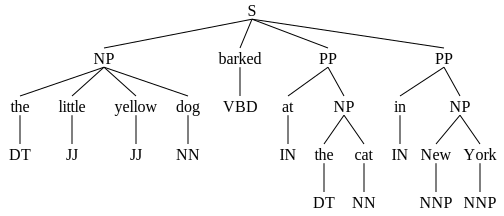

In [16]:
sentence = [("the", "DT"), ("little", "JJ"), ("yellow", "JJ"),("dog", "NN"),\
            ("barked", "VBD"), ("at", "IN"), ("the", "DT"), ("cat", "NN"), \
            ("in", "IN"), ("New", "NNP"), ("York", "NNP")]

grammar = r"""NP: {<DT>?<JJ>*(<NN>|<NNP>+)}
              PP: {<IN><NP>}"""

cp = nltk.RegexpParser(grammar)
result = cp.parse(sentence)
svgling.draw_tree(result)